## Packages:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data importation:

In [2]:
data = (pd.read_csv('sessions_with_orders.csv.gz', 
                    index_col=0,
                    parse_dates=[4, 5, 11, 13],
                    dtype={
                         'global_sources': 'category',
                         'device_type': 'category',
                         'device_model': 'category',
                         'order_channel': 'category',
                         'client_number': str
                    })
        .assign(
            duration=lambda df: pd.to_timedelta(df.duration),
            cvic=lambda df: df.cvic.fillna(0).astype(bool)
        ))

data.head()

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,session_id,visitor_id,nb_pages,session_start_date,session_end_date,global_sources,device_type,device_model,funnel,duration,session_date,client_number,order_date,order_channel,pre_tax_amount,cvic
0,d349ae2a2eea,0,1,2017-08-08 00:01:32,2017-08-08 00:01:32,Moteurs,Smartphone,iPhone,['accueil'],00:00:00,2017-08-08,NaN,NaT,NaN,NaN,False
1,582a96c58c22,0,5,2017-08-08 17:23:13,2017-08-08 17:24:51,Liens Sponsorisés,Tablette,iPad,"['category', 'category', 'category', 'category...",00:01:38,2017-08-08,NaN,NaT,NaN,NaN,False
2,6338e81bebb1,0,5,2017-08-08 17:21:46,2017-08-08 17:24:54,Liens Sponsorisés,Ordinateur,NaN,"['product', 'category', 'category', 'category'...",00:03:08,2017-08-08,NaN,NaT,NaN,NaN,False
3,0fe5731aa1a5,0,17,2017-08-08 16:57:07,2017-08-08 17:24:58,Moteurs,Tablette,sm-t560,"['accueil', 'accueil', 'product', 'category', ...",00:27:51,2017-08-08,NaN,NaT,NaN,NaN,False
4,3329bb2ada05,0,2,2017-08-08 17:01:37,2017-08-08 17:25:01,Accès Direct,Ordinateur,NaN,"['catalogue', 'catalogue']",00:23:24,2017-08-08,NaN,NaT,NaN,NaN,False


The first idea is to work only on the sessions that converted into sales. A good indicator for this is "pre_tax_amount" column. If an amount is specified, it means a transaction has been carried out. Conversely, if nan is specified, then we can be sure no transaction was carried out.
After trying different lines of codes, the easiest is simply filtering with the following boolean condition:

In [3]:
bool_ = data["pre_tax_amount"] < 10000
orders = data.loc[bool_,:]

We can retrieve the conversion rate from this data:

In [4]:
len(orders)/len(data) * 100

3.4680562255154666

In [5]:
orders.head()

,session_id,visitor_id,nb_pages,session_start_date,session_end_date,global_sources,device_type,device_model,funnel,duration,session_date,client_number,order_date,order_channel,pre_tax_amount,cvic
22,83c93dfbab37,284156,16,2017-08-08 17:10:32,2017-08-08 17:25:56,Liens Sponsorisés,Tablette,sm-t113,"['accueil', 'product', 'login_compte_internet'...",00:15:24,2017-08-08,-6378965108477891107,2017-08-08,Internet,43.58,True
37,944b8f77b285,706702,3,2017-08-08 17:22:52,2017-08-08 17:23:32,Accès Direct,Ordinateur,NaN,"['user_info', 'page', 'page']",00:00:40,2017-08-08,1780204980861060730,2017-08-08,Internet,38.08,False
40,f14c1edb0621,232488,4,2017-08-08 17:21:43,2017-08-08 17:23:35,Accès Direct,Ordinateur,NaN,"['accueil', 'page', 'user_info', 'page']",00:01:52,2017-08-08,6918728054835807575,2017-08-08,Internet,86.50,True
41,f14c1edb0621,232488,4,2017-08-08 17:21:43,2017-08-08 17:23:35,Accès Direct,Ordinateur,NaN,"['accueil', 'page', 'user_info', 'page']",00:01:52,2017-08-08,6918728054835807575,2017-08-08,Internet,86.50,True
42,f14c1edb0621,232488,4,2017-08-08 17:21:43,2017-08-08 17:23:35,Accès Direct,Ordinateur,NaN,"['accueil', 'page', 'user_info', 'page']",00:01:52,2017-08-08,6918728054835807575,2017-08-08,Internet,86.50,True


## Data analysis & visualisation:

### Selecting relevant variables

We see that we have some variables that are already a synthetisation of other variables. For example, "duration" is the difference between "session_start_date" and "session_end_date". We are therefore going to keep only the variables that can be easily integrated within the analysis workflow:

In [6]:
to_keep = ["nb_pages", "global_sources", "device_type", "duration", "pre_tax_amount", "cvic"]
df = orders.loc[:, to_keep]
df.head()

,nb_pages,global_sources,device_type,duration,pre_tax_amount,cvic
22,16,Liens Sponsorisés,Tablette,00:15:24,43.58,True
37,3,Accès Direct,Ordinateur,00:00:40,38.08,False
40,4,Accès Direct,Ordinateur,00:01:52,86.50,True
41,4,Accès Direct,Ordinateur,00:01:52,86.50,True
42,4,Accès Direct,Ordinateur,00:01:52,86.50,True


As we can see inside the previous dataframe, we have categorical variables in addition to quantitative ones. Therefore, the next step is to transform those categorical variables into dummy variables (equal to 0 or 1).
The following function handles this task at the dataframe level, where the expand_columns argument regroups the categorical variables we wish to convert with the pandas built-in "get_dummies" method: 

In [7]:
def prepare_dataframe(df, *expand_columns):
    for col in expand_columns:
        expand_df = pd.get_dummies(df.loc[:,[col]], columns=[col])
        result_df = pd.concat([df, expand_df], axis=1)
        df = result_df
    result_df = result_df.drop([col for col in expand_columns], axis=1)
    return result_df

df = prepare_dataframe(df, "global_sources", "device_type")
df["duration"] = df["duration"].apply(lambda t: t.total_seconds())
df["cvic"] = df["cvic"].map({True:"With Coupon", False:"Without Coupon"})
df.reset_index(drop=True, inplace=True)
df.head()        

,nb_pages,duration,pre_tax_amount,cvic,global_sources_Accès Direct,global_sources_Affiliation et partenaires,global_sources_Email marketing,global_sources_Flux RSS,global_sources_Liens Sponsorisés,global_sources_Moteurs,...,global_sources_Sites affluents,global_sources_Sites du Portail,global_sources_Sources naturelles personnalisées,global_sources_Webmails,device_type_Console,device_type_Indéterminés,device_type_Ordinateur,device_type_Smartphone,device_type_TV connectée,device_type_Tablette
0,16,924.0,43.58,With Coupon,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,3,40.0,38.08,Without Coupon,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,4,112.0,86.50,With Coupon,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,112.0,86.50,With Coupon,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,112.0,86.50,With Coupon,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### PCA dimensionality reduction

<p>The next step is to proceed to a PCA, in order to get the best (with the highest percentage of explained variance) 2-d representation of the initial datapoints. The idea is to assess whether the datapoints labelled "With Coupon" - so coming from catalog purchasers - constitute a proper cluster. On the following graph, these points are in red, and the other points in green.</p>
If there is a proper cluster of catalog purchasers (ie. of red points), we would  then be able to see the green points that are close to this cluster. This would allow us to eventually identity the purchasers that actually saw the products inside the catalog and then bought the product online.

In [8]:
features = [col for col in list(df.columns) if col not in ["cvic"]]
x = df.loc[:, features].values
y = df.loc[:, ["cvic"]].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plot_df = pd.concat([principalDf, df.loc[:,["cvic"]]], axis = 1)
plot_df.head()

,principal component 1,principal component 2,cvic
0,-1.661348,1.852207,With Coupon
1,-1.290651,-1.782583,Without Coupon
2,-1.194392,-1.689315,With Coupon
3,-1.194392,-1.689315,With Coupon
4,-1.194392,-1.689315,With Coupon


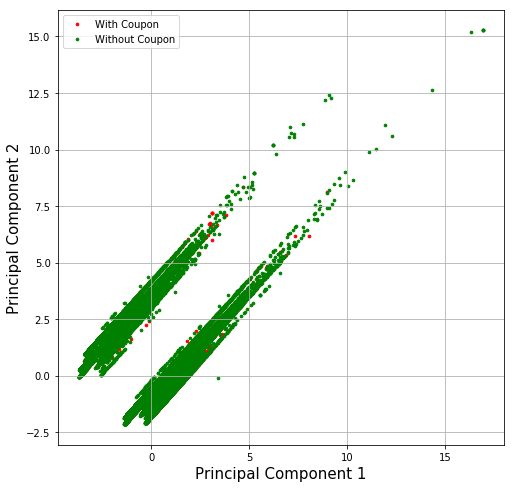

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['With Coupon', 'Without Coupon']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = plot_df['cvic'] == target
    ax.scatter(plot_df.loc[indicesToKeep, 'principal component 1']
               , plot_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 7)
ax.legend(targets)
ax.grid()
plt.show()

However, we see that there is no proper cluster of red points (purchasers with coupon), so at this point, we cannot draw further conclusion, in as much as the percentage of explained variance carried by the two first dimensions of the PCA-reduction is very low.

In [10]:
pca.explained_variance_ratio_

array([ 0.10797068,  0.09673074])

<b>We will therefore need to process the initial data, using some more qualitative metrics, which we will see in the next parts.</b>